## How to Artificial Intelligence?

There exists 2 basic containers in `PyTorch`:
- `nn.Sequential` - bases on defining module by module, implements `append` and `extends` to add new modules. Is used as a partial module in a custom `nn.Module` class
- `nn.Module` - main container. Custom models should inherit from this class and impelement `forward` method. Optionally, it can implement `backward` method for custom autograd method. Almost every node in the graph can be `nn.Module`: losses, activations, models, other math functions. 

### nn.Module
Every added `nn.Sequential` or `nn.Module` module automatically causes your class to add parameters, which those variables contain to custom containers. All layers and initializations must be performed in the constructor. Every `nn.Module` should implement `forward` to work properly. Moreover, it's printable :) (like in Keras: `.summary()` method).

## Dummy linear classifier

In [1]:
import torch
import torch.nn as nn

from collections import OrderedDict

class MyClassifier(nn.Module):
    def __init__(self, input_features, hidden_features, nb_classes):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('hidden_layer', nn.Linear(input_features, hidden_features)),
            ('activation', nn.ReLU()),
            ('output_layer', nn.Linear(hidden_features, nb_classes))
        ]))
        self.apply(self._init_layers)
    
    def _init_layers(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            m.weight.data.normal_(0, 0.01)
            m.bias.data.fill_(0)
        
    def forward(self, x):
        return self.layers(x)

Layers in the `nn.Sequential` can be passed as OrderedDict or list of layers. Most activations can be used as layers. Activations can be performed separately in the `forward` method using `torch.nn.functional` module.

Did you notice that we didn't perform `softmax` in the final layer? It's caused by the definitions of loss functions in the `PyTorch`. Authors performed many optimizations that were caused by equations reductions and thanks to this, calculations are performed faster. If you really want probabilities, just use `torch.nn.functional.softmax` or use own implementation during evaluation. 

In [2]:
print(MyClassifier(784, 100, 10))

MyClassifier(
  (layers): Sequential(
    (hidden_layer): Linear(in_features=784, out_features=100, bias=True)
    (activation): ReLU()
    (output_layer): Linear(in_features=100, out_features=10, bias=True)
  )
)


## Dataset

`torch.utils.data.Dataset` is a basic structure (data generator) that should be used during training. Thanks to this, `PyTorch` can manage on its own how to distribute data loading across many gpus and clusters. Every custom dataset should inherit from this class and implement `__len__` and `__getitem__` methods. That's all. Then you can pass this to the `DataLoader` which is a `Dataset` manager.

We won't implement `Samplers` which return indices which are passed to the `Dataset`.

In [18]:
from torch.utils.data import Dataset

import numpy as np

class MyDataset(Dataset):
    def __init__(self, mnist_set):
        self.mnist_set = mnist_set
    
    def __getitem__(self, index):
        sample, true_label = self.mnist_set[index]
        sample = np.array(sample).astype(np.float32).flatten()
        true_label = np.array(true_label).astype(np.float32)
        
        return torch.from_numpy(sample), torch.from_numpy(true_label)
    
    def __len__(self):
        return len(self.mnist_set)

In [19]:
import mnist_data
dataset = MyDataset(mnist_data.get_store()[0])

In [28]:
def get_acc(y_pred, y_true):
    _, y_pred_ind = torch.max(y_pred, dim=1)
    return (y_pred_ind == y_true).type(torch.FloatTensor).mean()

`DataLoader` can have passed also function `collate_fn` which tells what operations should be performed on the whole batch during training (such as reshaping etc.).

## Train and save classifier

In [35]:
from torch.utils.data import DataLoader
from torch.autograd import Variable

import sys
sys.path.append('..')

import mnist_data
import torch

        
def validate(model, loader, loss_fun, acc_fun):
    model.eval()
    losses = []
    accuarcies = []
    for idx, (data, target) in enumerate(loader):
        data, target = Variable(data), Variable(target)
        output = model(data)
        loss = loss_fun(output, target)
        acc = acc_fun(output, target)
        
        losses.append(loss.data.numpy())
        accuarcies.append(acc.data.numpy())
    model.train()
    return np.mean(losses), np.mean(accuarcies)


training_dataset, validation_dataset = mnist_data.get_store()[:-1]

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

model = MyClassifier(784, 100, 10)

loss_fun = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
epochs = 100
best_loss = np.inf
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    for idx, (data, target) in enumerate(training_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fun(output, target)
        loss.backward()
        optimizer.step()
    val_loss, val_acc = validate(model, validation_loader, loss_fun, get_acc)
    print(f'Val loss {val_loss}, val acc {val_acc}')
    if val_loss < best_loss:
        torch.save(model, 'checkpoint.pt')

Epoch 0/100
Val loss 0.2215607613325119, val acc 0.9379991888999939
Epoch 1/100


/home/kacper/anaconda3/envs/pytorch-workshop/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type MyClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss 0.1528313308954239, val acc 0.9583666324615479
Epoch 2/100
Val loss 0.128450408577919, val acc 0.9633586406707764
Epoch 3/100
Val loss 0.10743964463472366, val acc 0.9699480533599854
Epoch 4/100
Val loss 0.10639817267656326, val acc 0.9690495133399963
Epoch 5/100
Val loss 0.09212569147348404, val acc 0.9733426570892334
Epoch 6/100
Val loss 0.09272808581590652, val acc 0.9733426570892334
Epoch 7/100
Val loss 0.08359020948410034, val acc 0.9751397967338562
Epoch 8/100


KeyboardInterrupt: 

## Load model and predict

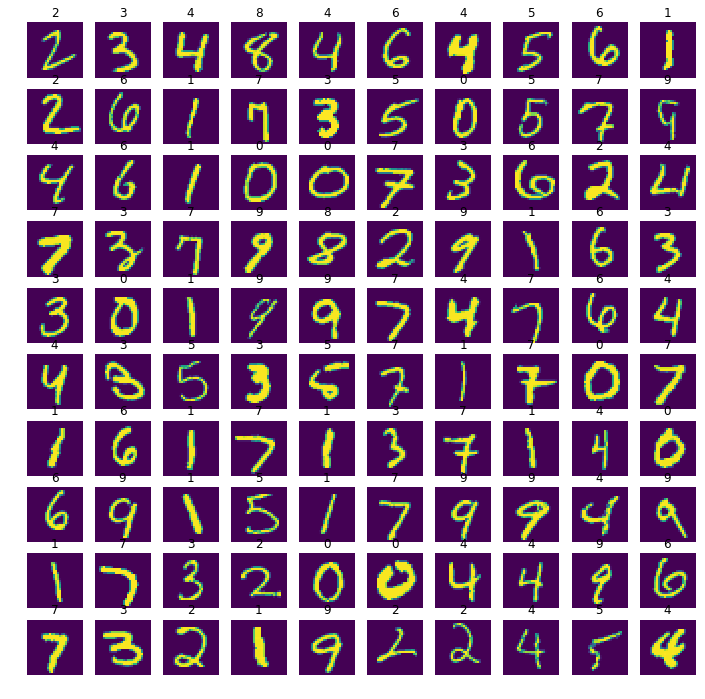

In [54]:
import matplotlib.pyplot as plt

model = torch.load('checkpoint.pt')
test_set = mnist_data.get_store()[-1][:100]
test_loader = DataLoader(test_set, shuffle=True, batch_size=32)

predicted_data = []
for idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    output = model(data)
    _, ind = torch.max(output, dim=1)
    numpy_data = data.data.numpy()
    pred_data = ind.data.numpy()
    for i in range(len(numpy_data)):
        predicted_data.append((numpy_data[i], pred_data[i]))
    
subplots = plt.subplots(10, 10, figsize=(12, 12))[1].flatten()
for i, pred in enumerate(predicted_data):
    subplots[i].axis('off')
    subplots[i].set_title(pred[1])
    subplots[i].imshow(pred[0].reshape((28, 28)))

`PyTorch` saves model using modified pickling procedure. It's simple as it is. During `torch.save` you can pass any argument to saving dict like an optimizer params of `Adam` and much more.